In [1]:
import os
os.chdir('/home/xzheng10/workspace/unsupervised_captioning')

/home/xzheng10/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xzheng10/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xzheng10/.conda/envs/tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xzheng10/.conda/envs/tf/lib/python3.7/site-packages/ten

INFO:tensorflow:Initializing vocabulary from file: data/word_counts.txt
INFO:tensorflow:Created vocabulary with 18669 words
Instructions for updating:
Use tf.cast instead.
image name: b'2347576.jpg'
classes: ['boot', 'building', 'hat', 'head', 'helmet', 'jacket', 'man', 'motorcycle', 'street', 'tire', 'wheel', 'window', 'windshield']
predicates: ['sitting on', 'with']


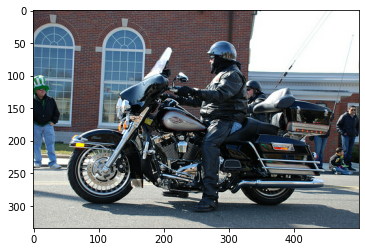

image name: b'2364666.jpg'
classes: ['beach', 'child', 'girl', 'house', 'kite', 'people', 'person', 'woman']
predicates: ['walking on']


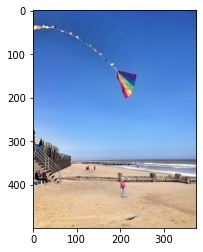

image name: b'2368717.jpg'
classes: ['banana', 'beach', 'building', 'ear', 'hair', 'head', 'leaf', 'man', 'people', 'person', 'roof', 'stand', 'surfboard']
predicates: ['holding', 'sitting on', 'walking on', 'with']


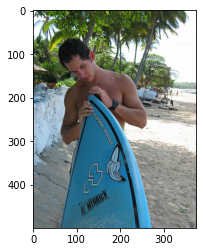

image name: b'2403988.jpg'
classes: ['bench', 'tree']
predicates: ['behind']


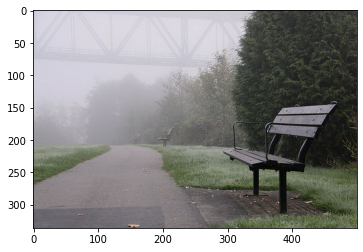

image name: b'2324742.jpg'
classes: ['building', 'ear', 'flag', 'hat', 'head', 'horse', 'leg', 'man', 'people', 'person', 'shirt', 'sidewalk', 'sign', 'street', 'tree', 'wheel']
predicates: ['has', 'with']


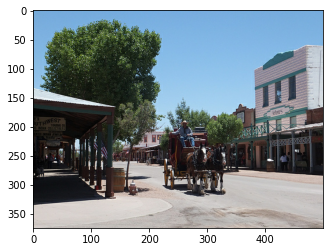

image name: b'2321665.jpg'
classes: ['bag', 'bench', 'coat', 'hair', 'head', 'jacket', 'man', 'person', 'sign', 'train', 'window', 'woman']
predicates: ['with']


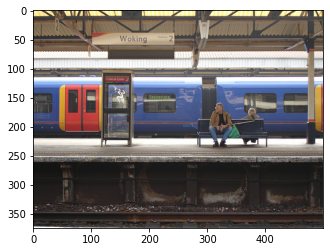

image name: b'2408761.jpg'
classes: ['bench', 'building', 'clock', 'fence', 'man', 'people', 'person', 'pole', 'roof', 'table', 'umbrella', 'window', 'woman']
predicates: ['has', 'over', 'with']


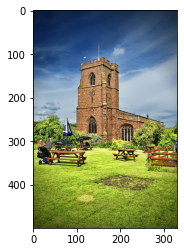

image name: b'2342018.jpg'
classes: ['helmet', 'man', 'shirt', 'skateboard', 'street', 'wheel']
predicates: []


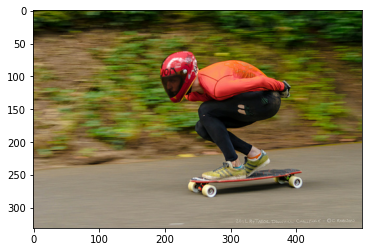

image name: b'2358907.jpg'
classes: ['glove', 'hand', 'hat', 'helmet', 'logo', 'man', 'mouth', 'player', 'shirt', 'sign', 'sneaker']
predicates: ['with']


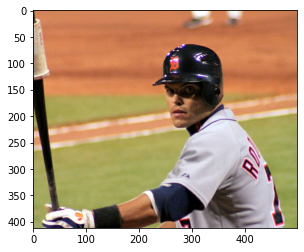

image name: b'2412116.jpg'
classes: ['man', 'motorcycle', 'wheel', 'helmet', 'sidewalk']
predicates: ['has', 'riding', 'standing on', 'with']


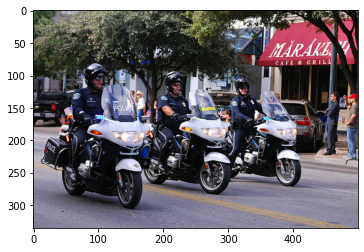

In [2]:
# _*_coding:utf-8_*_
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
from PIL import Image  #注意Image,后面会用到
import matplotlib.pyplot as plt
import numpy as np
from misc_fn import random_drop
import chardet
import json

FLAGS = tf.flags.FLAGS

AUTOTUNE = tf.data.experimental.AUTOTUNE

cwd='/home/xzheng10/workspace/unsupervised_captioning/data/coco/'

TF_MODELS_PATH = '/home/xzheng10/workspace/tf_models'
sys.path.insert(0, TF_MODELS_PATH + '/research/im2txt/im2txt')
sys.path.append(TF_MODELS_PATH + '/research')
sys.path.append(TF_MODELS_PATH + '/research/object_detection')
from inference_utils import vocabulary

vocab = vocabulary.Vocabulary('data/word_counts.txt')
total_classes = np.load('data/obj_pred_classes.npy', allow_pickle=True).item()
predicate_classes = list(total_classes['predicate_classes'])


def load_info(info_file):
    """
    Loads the file containing the visual genome label meanings
    :param info_file: JSON
    :return: ind_to_classes: sorted list of classes
             ind_to_predicates: sorted list of predicates
    """
    info = json.load(open(info_file, 'r'))
    info['label_to_idx']['__background__'] = 0
    info['predicate_to_idx']['__background__'] = 0

    class_to_ind = info['label_to_idx']
    predicate_to_ind = info['predicate_to_idx']
    ind_to_classes = sorted(class_to_ind, key=lambda k: class_to_ind[k])
    ind_to_predicates = sorted(predicate_to_ind, key=lambda k: predicate_to_ind[k])

    # return ind_to_classes, ind_to_predicates
    return ind_to_predicates



def parse_image(serialized):
  """Parses a tensorflow.SequenceExample into an image and detected objects.

  Args:
    serialized: A scalar string Tensor; a single serialized SequenceExample.

  Returns:
    encoded_image: A scalar string Tensor containing a JPEG encoded image.
    classes: A 1-D int64 Tensor containing the detected objects.
    scores: A 1-D float32 Tensor containing the detection scores.
  """
  context, sequence = tf.parse_single_sequence_example(
    serialized,
    context_features={
      'image/name': tf.FixedLenFeature([], dtype=tf.string),
      'image/data': tf.FixedLenFeature([], dtype=tf.string)
    },
    sequence_features={
      'classes': tf.FixedLenSequenceFeature([], dtype=tf.int64),
      'relationships': tf.FixedLenSequenceFeature([], dtype=tf.int64)
      # 'scores': tf.FixedLenSequenceFeature([], dtype=tf.float32),
    })
  name = context['image/name']
  encoded_image = context['image/data']
  classes = tf.to_int32(sequence['classes'])
  relationships = tf.to_int32(sequence['relationships'])
  return name, encoded_image, classes, relationships

def preprocess_image(name, encoded_image, classes, relationships):
  """Decodes an image."""

  image = tf.image.decode_jpeg(encoded_image)
  image = tf.image.convert_image_dtype(image,dtype=tf.uint8)
  # image = tf.image.decode_jpeg(encoded_image, 3)
  # image = tf.image.convert_image_dtype(image, tf.float32)
  # image = tf.image.resize_images(image, [346, 346])
  # image = tf.random_crop(image, [299, 299, 3])
  # image = image * 2 - 1
  return name, image, classes, relationships


def read_test(input_file):
    ind_to_pred = load_info('../data_release/VG-SGG-dicts.json')
    # 用dataset读取TFRecords文件
    dataset = tf.data.TFRecordDataset(input_file)
    dataset = dataset.map(parse_image)
    dataset = dataset.map(preprocess_image)
    # dataset = dataset.batch(1, drop_remainder=True)
    iterator = dataset.make_one_shot_iterator()  # 从dataset中实例化了一个Iterator，这个Iterator是一个“one shot iterator”，即只能从头到尾读取一次

    with tf.Session() as sess:
      for i in range(10):
        name, image, classes, relationships = sess.run(iterator.get_next())
        # name = features['name']
        # name = name.decode()
        # img_data = features['encoded_image']
        # classes = features['classes']

        # 从bytes数组中加载图片原始数据，并重新reshape，它的结果是 ndarray 数组
        # image_data = np.fromstring(image_data, dtype=np.uint8)
        # image_data = np.reshape(img_data, shape)
        # image = tf.image.decode_jpeg(image_data)
        # image = tf.image.convert_image_dtype(image,dtype=tf.uint8)


        img=Image.fromarray(image, 'RGB')#这里Image是之前提到的
        img.save(cwd+str(i)+'.jpg')#存下图片
        cs = [vocab.id_to_word(x) for x in classes]
        rl = [ind_to_pred[y] for y in relationships]
        # n = n.decode('utf8')
        
        plt.figure(i) #图像显示  
        plt.imshow(image)
        print("image name:", name)
        print("classes:", cs)
        print("predicates:", rl)
        plt.show()
        # plt.figure()
        # # 显示图片
        # plt.imshow(image_data)
        # plt.show()

        # # 将数据重新编码成jpg图片并保存
        # img = tf.image.encode_jpeg(image_data)
        # tf.gfile.GFile('cat_encode.png', 'wb').write(img.eval())


if __name__ == '__main__':
    read_test("data/GT_image_train.tfrec")


